# Stochasticity

Everything that we did so far is determenistic. All inhomoneities are derived from the fields that are seeded in the ICs. In other words, for one IC field and a given set of parameters we got only one solution. However, it is not the case, since we do not resolve everything. In [Kaurov (2017)](https://ui.adsabs.harvard.edu/#abs/2017arXiv170904353K/abstract) I have shown that the effect of pertrubations on small scales propagating to large scales through ionizing radiation is not negligible. 

### Toy model

Let's assume a homogeneous box with an isolated galaxy in the center. The usual excursion set formalism predicts spherical bubble growing around it. Let's skip the step of applying the excursion set model and manually create the field. The `h_field_test` is the field of some parameter $h$ that can be mapped to the reionization field, i.e. the isocontour of this field should be a sphere.

In [1]:
# we start with importing all necessary components
%matplotlib inline

import numpy as np
from numpy import sin, cos, pi

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import rankdata, norm
from scipy.interpolate import griddata

# FastPM related libraries to work with snapshots
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh

from nbodykit.cosmology import Planck15
from nbodykit.cosmology import EHPower

from nbodykit.lab import *
from nbodykit import setup_logging, style

from skimage import measure

from reionprimer import *

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


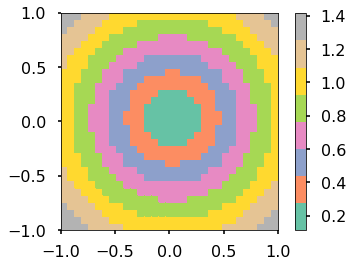

In [2]:
Nt = 32
x, y, z = np.mgrid[-1:1:32j, -1:1:32j, -1:1:32j]
# print(len(x))
r2 = (x**2+y**2+z**2+0.01)
h_field_test = r2**.5
# h_field_test = rankdata(h_field_test.flat).reshape(h_field_test.shape)/Nt**3
plt.pcolor(x[:, 16, :], z[:, 16, :], h_field_test[:,16,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')
plt.colorbar()

As expected, we see spherical contours of ionization fronts. However, we know that a galaxy emits photons inhomogeneously. The escape fraction of ionizing photons is not spherically symmetric, and the total production of photons is not constant in time. Therefore, in a more realistic model these contours have to be distorted. 

However, they cannot be distorted randomly! Since the source in this toy model located only in the center, the isocontours can be perturbed only along the line connecting them with the center. Therefore, let's find the vector field along which the fronts can be perturbed. It is simply the gradient of the $h$ field.

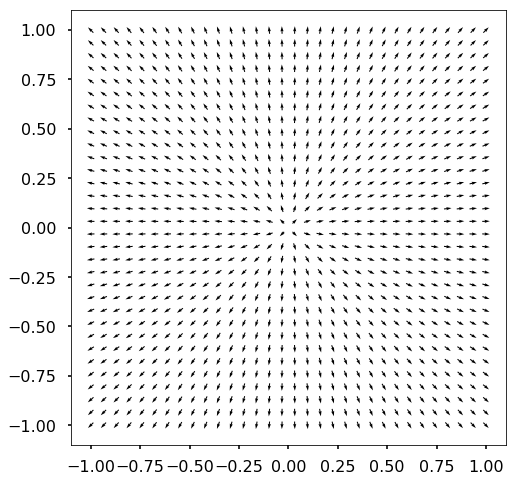

In [3]:
# The three components of the vector field are:
grad0, grad1, grad2 = np.gradient(h_field_test)

# We want to normalize it (which is not necessary, but we will do it here):
norm = np.sqrt(grad0**2+grad1**2+grad2**2)
norm[norm==0] = 1e10
grad0 *= 1/norm
grad1 *= 1/norm
grad2 *= 1/norm

# Now we plot the center slice:
plt.figure(figsize=(8,8))
Q = plt.quiver(x[:, :, 0], y[:, :, 0], grad0[:, :, 16], grad1[:, :, 16],
               pivot='mid')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

Now the question is by how much we want to perturb the ionization fronts. We want to construct the field, `deflection_potential`, that represents how hard is it for the ionization front to propagate in this region.

To illustrate we will use two components.
* Comlpetely random component which accounts for the stochastic effects.
* The **disk** component. We assume that disk is in x-y plane, and therefore (arguably) the escape fraction is smaller in this plane.

(32, 32, 32)


Text(0.5,0,'x-axis')

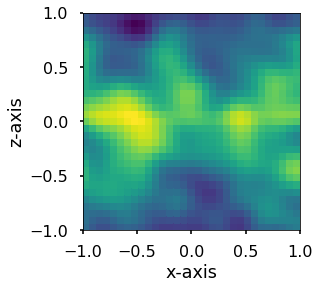

In [4]:
# Random seed for reproducibility
np.random.seed(314)

# First, we add random component
deflection_potential = np.random.normal(0,1,size=[Nt, Nt, Nt])
deflection_potential = np.fft.rfftn(deflection_potential)
# deflection_potential *= np.fft.rfftn((r2+0.01)**-3)
deflection_potential = smooth(deflection_potential, 1.8, Nt, 'gaussian')


# Adding the 'disk' component
deflection_potential += 1./(np.abs(z)+0.3)**.2
print(deflection_potential.shape)


deflection_potential -= deflection_potential.mean()
deflection_potential /= deflection_potential.std()

# Plotting the field
plt.pcolor(x[:, 16, :], z[:, 16, :], deflection_potential[:,16,:])
plt.axis('equal')
plt.gca().set_adjustable('box-forced')
plt.ylabel('z-axis')
plt.xlabel('x-axis')



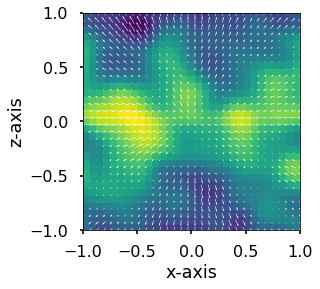

In [5]:
grad0x = - grad0 * deflection_potential
grad1x = - grad1 * deflection_potential
grad2x = - grad2 * deflection_potential


plt.pcolor(x[:, 16, :], z[:, 16, :], deflection_potential[:,16,:])
plt.ylabel('z-axis')
plt.xlabel('x-axis')
Q = plt.quiver(x[:, 16, :], z[:, 16, :], grad0x[:, 16, :], grad2x[:, 16, :],
               pivot='mid', units='inches', color='w')

plt.axis('equal')
plt.gca().set_adjustable('box-forced')

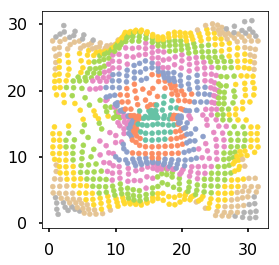

In [6]:
grid_0, grid_1, grid_2 = 0.5 + np.mgrid[0:Nt, 0:Nt, 0:Nt]

# grad_0 = grad0x[np.floor(grid_0_shifted).astype(int), 
#                 np.floor(grid_1_shifted).astype(int),
#                 np.floor(grid_2_shifted).astype(int)].copy()
# grad_1 = grad1x[np.floor(grid_0_shifted).astype(int), 
#                 np.floor(grid_1_shifted).astype(int),
#                 np.floor(grid_2_shifted).astype(int)].copy()
# grad_2 = grad2x[np.floor(grid_0_shifted).astype(int), 
#                 np.floor(grid_1_shifted).astype(int),
#                 np.floor(grid_2_shifted).astype(int)].copy()
dt = .15

grid_0_shifted = grid_0.copy()
grid_1_shifted = grid_1.copy()
grid_2_shifted = grid_2.copy()

for i in range(10):
#     print(i)
    grad_0 = grad0x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_1 = grad1x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_2 = grad2x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    
    norm = deflection_potential[np.floor(grid_0_shifted).astype(int), 
                np.floor(grid_1_shifted).astype(int),
                np.floor(grid_2_shifted).astype(int)]
    
#     print(grad_0)
    grid_0_shifted = grid_0_shifted + grad_0*dt*norm
    grid_1_shifted = grid_1_shifted + grad_1*dt*norm
    grid_2_shifted = grid_2_shifted + grad_2*dt*norm
    
    grid_0_shifted = np.mod(grid_0_shifted, Nt)
    grid_1_shifted = np.mod(grid_1_shifted, Nt)
    grid_2_shifted = np.mod(grid_2_shifted, Nt)
#     print(grid_2_shifted)

# for i in range(30):
#     grid_0_shifted += grad0*dt
#     grid_1_shifted += grad1*dt
#     grid_2_shifted += grad2*dt
    
values = h_field_test

plt.scatter(grid_0_shifted[:,16,:], grid_2_shifted[:,16,:], c=values[:,16,:], s=25.0, cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

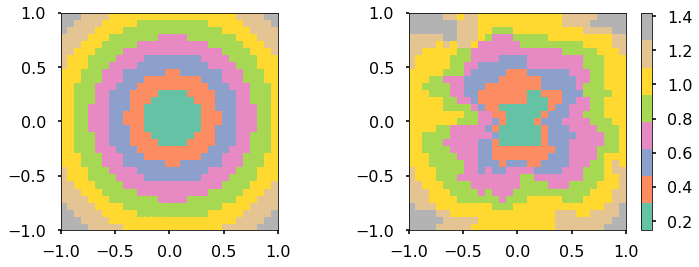

In [7]:
from scipy.interpolate import griddata


values = h_field_test.flatten()
pos = np.array([grid_0_shifted.flatten(), grid_1_shifted.flatten(), grid_2_shifted.flatten()]).T

h_field_test_distorted = griddata(pos, values, (grid_0, grid_1, grid_2), method='nearest', fill_value=np.nan)
# h_field_test_distorted = rankdata(f_field_test_distorted.flat).reshape([Nt,Nt,Nt])/Nt**3

plt.figure(figsize=(12,4))

ax = plt.subplot(121)
plt.pcolor(x[:, 16, :], z[:, 16, :], h_field_test[:,16,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

plt.subplot(122, sharex=ax,sharey=ax)
plt.pcolor(x[:, 16, :], z[:, 16, :], h_field_test_distorted[:,16,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

plt.colorbar()



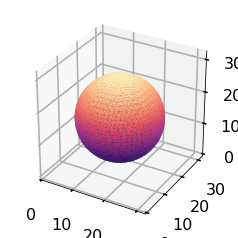

In [8]:
verts, faces = measure.marching_cubes_classic(h_field_test, 0.8, spacing=(1, 1, 1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='magma', lw=1)

ax.set_aspect('equal', 'box')
ax.get_xaxis().set_visible(False)
ax.set_xlim([0,Nt])
ax.set_ylim([0,Nt])
ax.set_zlim([0,Nt])
plt.show()


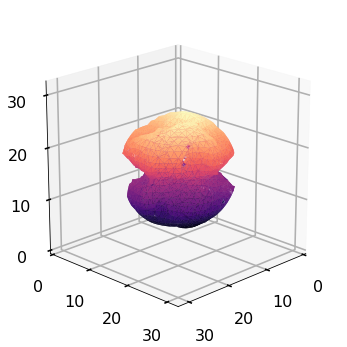

In [9]:
verts, faces = measure.marching_cubes_classic(h_field_test_distorted, 0.7, spacing=(1, 1, 1))

def animate(i):
    ax.view_init(elev=(i-6.)*4., azim=45)
    return fig,

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal', 'box')
# ax.get_xaxis().set_visible(False)
ax.set_xlim([0,Nt])
ax.set_ylim([0,Nt])
ax.set_zlim([0,Nt])
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                    cmap='magma', lw=2, shade=True)

ani = animation.FuncAnimation(fig, animate,
                               frames=12, interval=200, blit=True)

HTML(ani.to_jshtml(default_mode='reflect'))

#### Pros and Cons

[+] This method preserves physical order in which cells are ionized.

[-] The random stochastic component has to be motivated by something. For instance,by a simulation. However, how to do it is not completely clear.

___

## Full example

Now we want to move from a toy model to a full model. We will use the calculated reionization history from the previous sections.

First, we gnerate a realization of the redshift of ionization field (see previous 02 notebook for details).

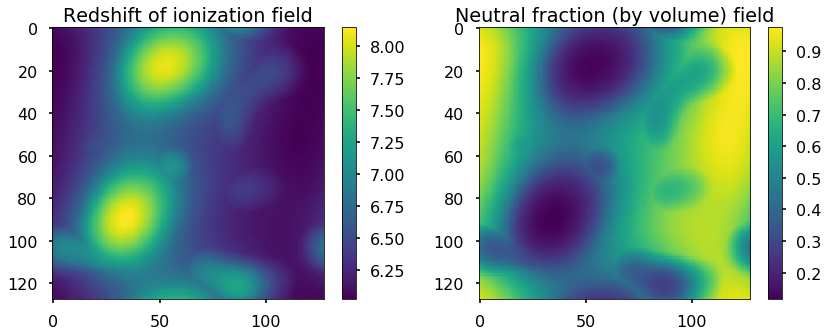

In [10]:
N=128
boxsize=10

part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')
q = part.to_mesh(Nmesh=N)
q = q.to_field()

halos = BigFileCatalog('fastpm_0.1250/fof/0.200/',header='Header')

M = np.array(halos['Mass'])
pos = np.array(halos['CMPosition'])

# we want to take only halos above 10^10 M_\Sun
filt = (M>1e9)

halo_field_m = np.zeros([N,N,N])

for i,(m,x,y,z) in enumerate(zip(M[filt],
                                 (pos[filt,0])/boxsize*N, 
                                 (pos[filt,1])/boxsize*N, 
                                 (pos[filt,2])/boxsize*N)):
    halo_field_m[int(x),int(y),int(z)] += 1.0 * m


# halo_field += q*1e10

def barrier(s, h):
#     return s*0 + 0.9
    return 4*(np.log10(s)+0.0)**2+h

def r_barrier(s, v):
    return v-4*(np.log10(s)+0.0)**2

sm_scales=np.array([1,2,4,8,16,32,64,128,256])
halo_field = halo_field_m + q*1e-2
field = get_trajectories(halo_field, sm_scales=sm_scales, filter_mode='gaussian', normalization='rankorder')

h_field = np.zeros([N,N,N,len(sm_scales)])
for i,scale in enumerate(sm_scales):
    h_field[:, :, :, i] = r_barrier(N/scale/boxsize, field[:,:,:,i])

h_field = h_field.max(3)

z_list = np.linspace(15,5,100)
f_list = reion_history(z_list)
f_field, z_field = convert_to_h_field(h_field, z_list, f_list)

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(z_field[0,:,:])
plt.title('Redshift of ionization field')
plt.colorbar()
plt.subplot(122)
plt.imshow(f_field[0,:,:])
plt.title('Neutral fraction (by volume) field')
plt.colorbar()

Now we generate the `deflection_potential`. Here, insteadof using the 'disk' component like in the toy example above, we use the density field. For the stochastic component we adopt white noise smoothed with a gaussian kernel. One can use any scalar field.

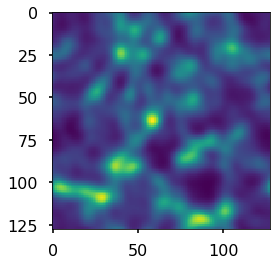

In [18]:
deflection_potential = np.fft.rfftn(q * 1e0 + np.random.normal(0,1,size=[N,N,N]))

x,y,z = np.mgrid[:N,:N,:N]
x[x>N/2] = N - x[x>N/2]
y[y>N/2] = N - y[y>N/2]
z[z>N/2] = N - z[z>N/2]
r2 = (x**2+y**2+z**2)

# deflection_potential *= np.fft.rfftn((r2+1)**-.7)
# deflection_potential = np.fft.irfftn(deflection_potential)

deflection_potential = smooth(deflection_potential, 3, N,'gaussian')

deflection_potential -= deflection_potential.mean()
deflection_potential /= deflection_potential.std()

plt.imshow(deflection_potential[0,:,:])

Now we generate the vector field along which we allow the ionization fronts to be perturbed.

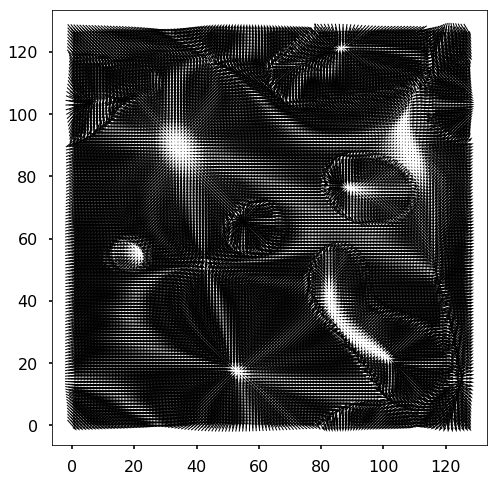

In [19]:
# The three components of the vector field are:
grad0, grad1, grad2 = np.gradient(h_field)

# We want to normalize it (which is not necessary, but we will do it here):
norm = np.sqrt(grad0**2+grad1**2+grad2**2)
norm[norm==0] = 1e10
grad0 *= 1/norm
grad1 *= 1/norm
grad2 *= 1/norm

# Now we plot the center slice:
plt.figure(figsize=(8,8))
Q = plt.quiver(grad2[0, :, :], grad1[0, :, :],
               pivot='mid', scale=30.0)
plt.axis('equal')
# plt.xlim([20,60])
# plt.ylim([60,100])
plt.gca().set_adjustable('box-forced')

In [20]:
grad0x = - grad0 #* deflection_potential
grad1x = - grad1 #* deflection_potential
grad2x = - grad2 #* deflection_potential


# plt.pcolor(x[:, 16, :], z[:, 16, :], deflection_potential[:,16,:])
# plt.ylabel('z-axis')
# plt.xlabel('x-axis')
# Q = plt.quiver(x[:, 16, :], z[:, 16, :], grad0x[:, 16, :], grad2x[:, 16, :],
#                pivot='mid', units='inches', color='w')

# plt.axis('equal')
# plt.gca().set_adjustable('box-forced')

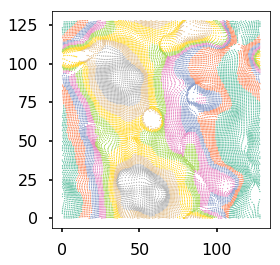

In [21]:
grid_0, grid_1, grid_2 = 0.5 + np.mgrid[0:N, 0:N, 0:N]

dt = .35

grid_0_shifted = grid_0.copy()
grid_1_shifted = grid_1.copy()
grid_2_shifted = grid_2.copy()

for i in range(10):
#     print(i)
    grad_0 = grad0x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_1 = grad1x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    grad_2 = grad2x[np.floor(grid_0_shifted).astype(int), 
                    np.floor(grid_1_shifted).astype(int),
                    np.floor(grid_2_shifted).astype(int)]
    
    norm = deflection_potential[np.floor(grid_0_shifted).astype(int), 
                np.floor(grid_1_shifted).astype(int),
                np.floor(grid_2_shifted).astype(int)]
    
    grid_0_shifted = grid_0_shifted + grad_0*dt*norm
    grid_1_shifted = grid_1_shifted + grad_1*dt*norm
    grid_2_shifted = grid_2_shifted + grad_2*dt*norm
    
    grid_0_shifted = np.mod(grid_0_shifted, N)
    grid_1_shifted = np.mod(grid_1_shifted, N)
    grid_2_shifted = np.mod(grid_2_shifted, N)
    
values = h_field

plt.scatter(grid_2_shifted[0,:,:], grid_1_shifted[0,:,:], c=values[0,:,:], s=.5, cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

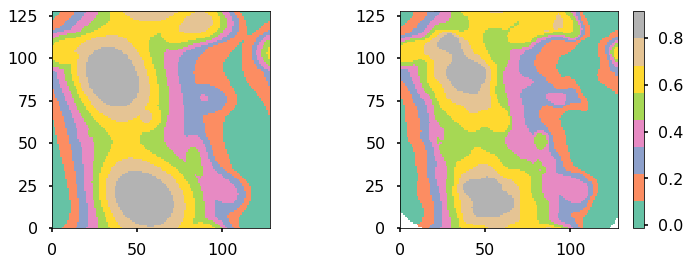

In [22]:
from scipy.interpolate import griddata


values = h_field.flatten()
pos = np.array([grid_0_shifted.flatten(), grid_1_shifted.flatten(), grid_2_shifted.flatten()]).T

h_field_distorted = griddata(pos, values, (grid_0, grid_1, grid_2), method='linear', fill_value=np.nan)
# h_field_test_distorted = rankdata(f_field_test_distorted.flat).reshape([Nt,Nt,Nt])/Nt**3

plt.figure(figsize=(12,4))

ax = plt.subplot(121)
plt.pcolor(h_field[0,:,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

plt.subplot(122, sharex=ax,sharey=ax)
plt.pcolor(h_field_distorted[0,:,:],cmap='Set2')
plt.axis('equal')
plt.gca().set_adjustable('box-forced')

plt.colorbar()




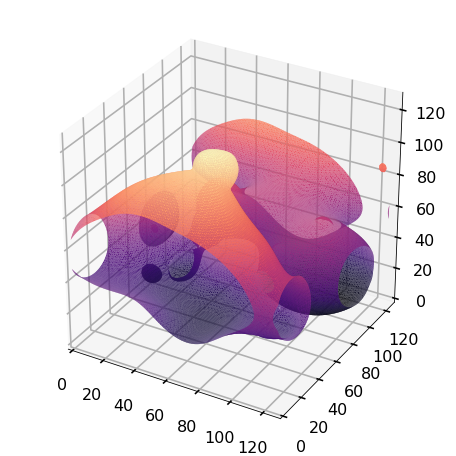

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/skimage/measure/_marching_cubes_classic.py:347: RuntimeWarning: invalid value encountered in less
  indices = (dotproducts < 0).nonzero()[0]


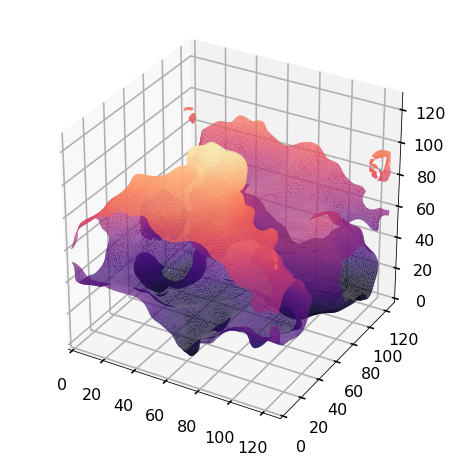

In [23]:
verts, faces = measure.marching_cubes_classic(h_field, 0.7, spacing=(1, 1, 1))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='magma', lw=1)

ax.set_aspect('equal', 'box')
ax.get_xaxis().set_visible(False)
ax.set_xlim([0,N])
ax.set_ylim([0,N])
ax.set_zlim([0,N])
plt.show()


verts, faces = measure.marching_cubes_classic(h_field_distorted, 0.7, spacing=(1, 1, 1))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='magma', lw=1)

ax.set_aspect('equal', 'box')
ax.get_xaxis().set_visible(False)
ax.set_xlim([0,N])
ax.set_ylim([0,N])
ax.set_zlim([0,N])
plt.show()


